In [1]:
from __future__ import annotations

import json
import os
import re
from pathlib import Path
from typing import (
    Any,
    Union,  # noqa: F401
)
import random
import numpy as np
import pandas as pd
import anndata as ad
from scanpy import logging as logg
from scipy.sparse import csr_matrix
from sklearn import neighbors
import squidpy as sq
import scanpy as sc
import scipy
import matplotlib.pyplot as plt
import matplotlib

from squidpy._constants._pkg_constants import Key
from squidpy.datasets._utils import PathLike
from squidpy.read._utils import _load_image, _read_counts

from cell2location import run_colocation


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/usr/local/lib/python3.10/dist-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and w

In [2]:
matplotlib.rcParams.update({'font.size': 15})


In [3]:
merge_dataset = sc.read_h5ad("/datastore3/RossOlympia/paper_analysis_MergeSplitUnroll/day7_2/sp_c2c_annotated_GPU.h5ad")

In [4]:
merge_dataset

AnnData object with n_obs × n_vars = 3964 × 15184
    obs: 'in_tissue', 'array_row', 'array_col', 'total_counts', 'location', 'spot_id', 'basement_layer', 'centre', 'sections', 'leiden_cluster', 'length', 'depth', 'unrolledSections', '_indices', '_scvi_batch', '_scvi_labels', 'Activated Cd4+ T cell', 'B cell', 'Basophil', 'Cd4+ T cell', 'Cd8+ T cell', 'DC', 'Endocrine', 'Enterocyte', 'Enterocyte.Progenitor', 'GC B cell', 'Goblet', 'ILC1', 'ILC2', 'ILC3', 'LTi cell', 'Macrophage', 'Mast cell', 'NK cell', 'NKT cell', 'Neutrophil', 'Plasma cell', 'Stem', 'TA', 'TA.Early', 'Tuft', 'gammaDelta T cell', 'pDC'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'diffmap_evals', 'draw_graph', 'leiden_cluster_sizes', 'mod', 'neighbors', 'paga', 'spatial'
    obsm: 'X_diffmap', 'X_draw_graph_kk', 'adjusted_spatial', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf'

In [5]:
#save the 'adjusted_spatial' obs as 'length_depth'
merge_dataset.obsm['length_depth'] = merge_dataset.obsm['adjusted_spatial'].copy()

#concatenate the 'adjusted_spatial' and 'spatial' obs together. This is so cell2location can break up the distinct sections 
#Perhaps I could add up the lengths of all the sections, then change their values to be seperated across the sum of the lengths (make sure there are gaps between them)

#save the 'spatial' obs as 'old_spatial'
merge_dataset.obsm['old_spatial'] = merge_dataset.obsm['spatial'].copy()


#make the 'spatial' obs equal to the 'adjusted_spatial', so the uns matches (cell2location NMF requires this, otherwise it has problems)
merge_dataset.obsm['spatial'] = np.c_[merge_dataset.obsm['adjusted_spatial'].copy(), merge_dataset.obsm['old_spatial'].copy()]

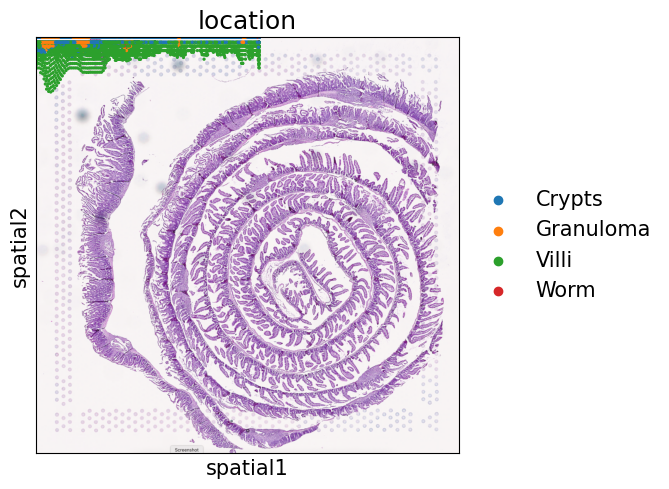

In [6]:
sq.pl.spatial_scatter(merge_dataset, color = "location")


In [7]:
res_dict, merge_dataset = run_colocation(
    merge_dataset,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': [7], # IMPORTANT: use a wider range of the number of factors (5-30)
      'n_restarts': 3 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'/datastore3/RossOlympia/paper_analysis_MergeSplitUnroll/day7_2/colocatedComb/'}
)


res_dict['n_fact7']['mod'].plot_cell_type_loadings()
plt.savefig("/datastore3/RossOlympia/paper_analysis_MergeSplitUnroll/day7_2/7_factor_NMF.pdf",
                bbox_inches='tight')
plt.close()

### Analysis name: CoLocatedGroupsSklearnNMF_7combinations_3964locations_27factors
Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0


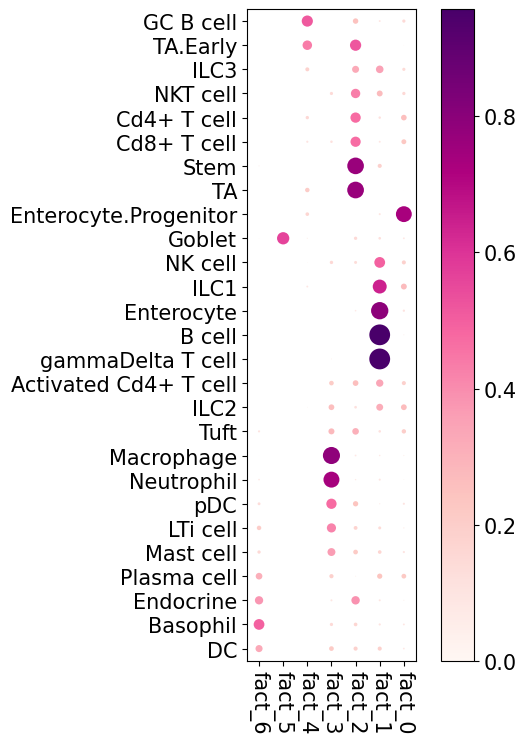

In [14]:
matplotlib.rcParams.update({'font.size': 15})
res_dict['n_fact7']['mod'].plot_cell_type_loadings()

In [9]:
merge_dataset.obsm['spatial'] = merge_dataset.obsm['old_spatial'].copy()
merge_dataset.obs.columns

Index(['in_tissue', 'array_row', 'array_col', 'total_counts', 'location',
       'spot_id', 'basement_layer', 'centre', 'sections', 'leiden_cluster',
       'length', 'depth', 'unrolledSections', '_indices', '_scvi_batch',
       '_scvi_labels', 'Activated Cd4+ T cell', 'B cell', 'Basophil',
       'Cd4+ T cell', 'Cd8+ T cell', 'DC', 'Endocrine', 'Enterocyte',
       'Enterocyte.Progenitor', 'GC B cell', 'Goblet', 'ILC1', 'ILC2', 'ILC3',
       'LTi cell', 'Macrophage', 'Mast cell', 'NK cell', 'NKT cell',
       'Neutrophil', 'Plasma cell', 'Stem', 'TA', 'TA.Early', 'Tuft',
       'gammaDelta T cell', 'pDC', 'sample', 'mean_nUMI_factorsfact_0',
       'mean_nUMI_factorsfact_1', 'mean_nUMI_factorsfact_2',
       'mean_nUMI_factorsfact_3', 'mean_nUMI_factorsfact_4',
       'mean_nUMI_factorsfact_5', 'mean_nUMI_factorsfact_6'],
      dtype='object')

In [10]:
#Marta's sections of interest are the one on the very left of the plot

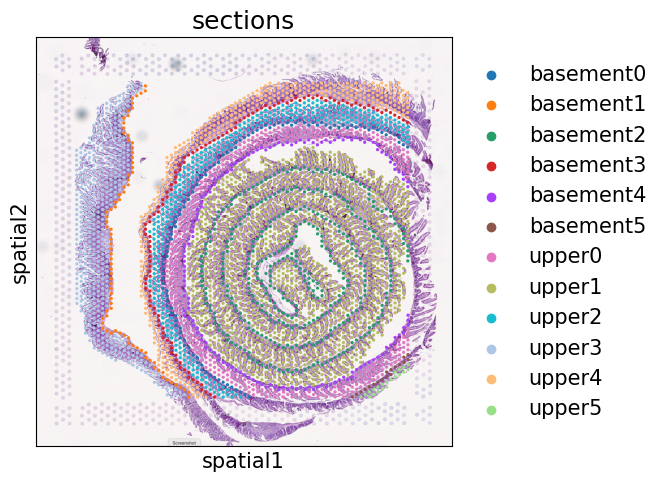

In [13]:
matplotlib.rcParams.update({'font.size': 15})

sq.pl.spatial_scatter(merge_dataset, color = "sections")

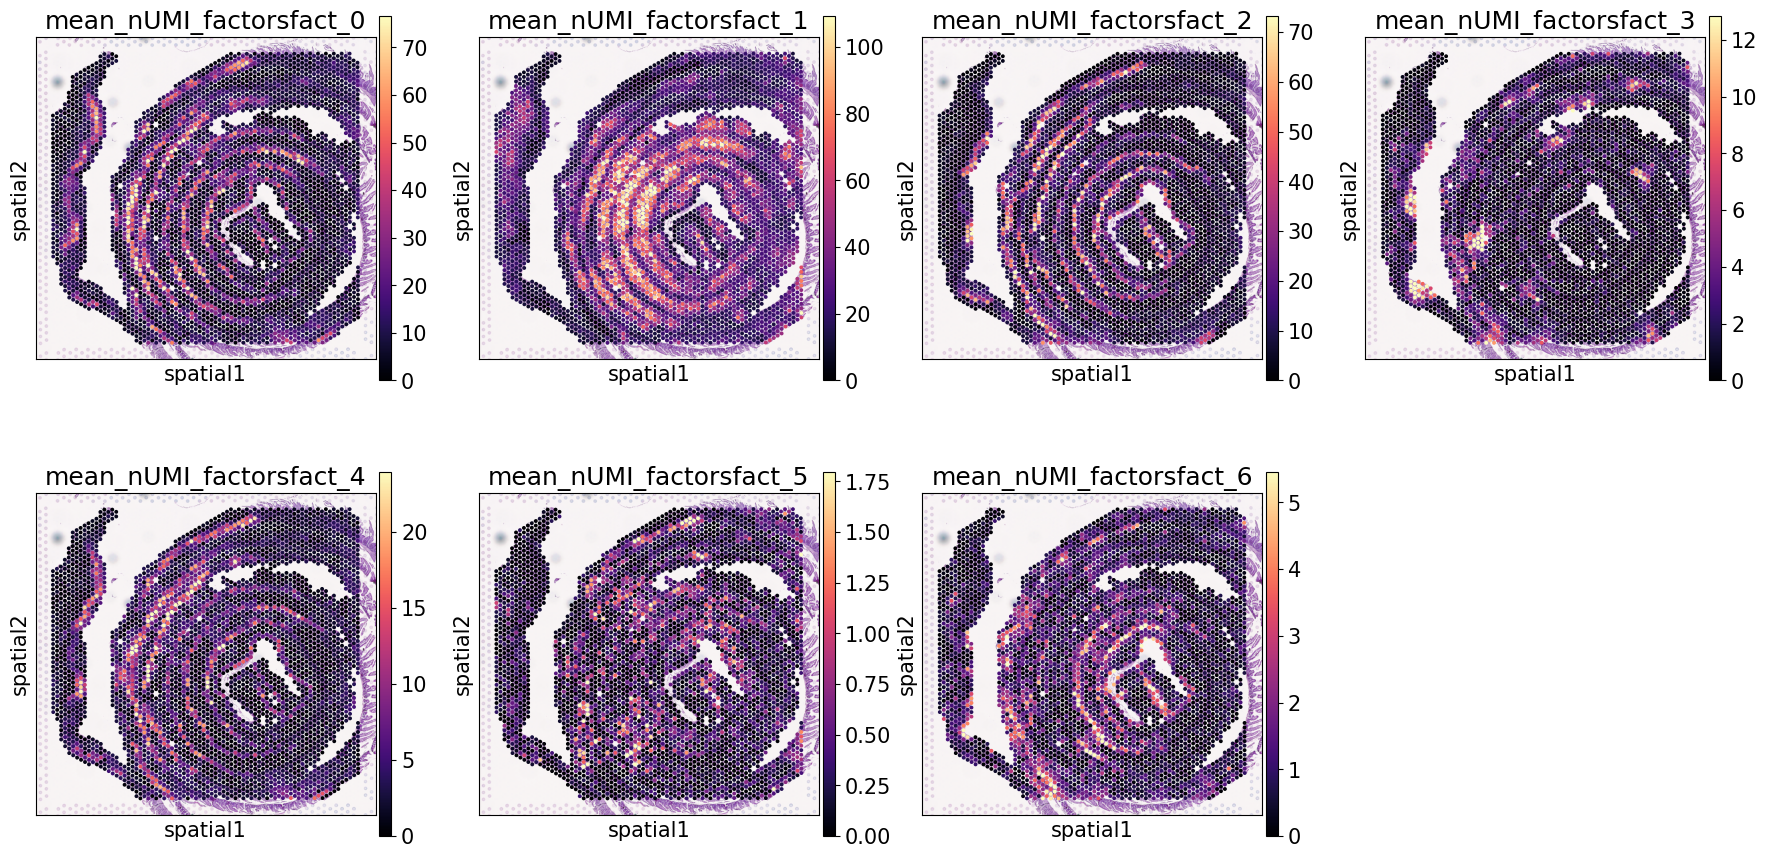

In [15]:
factor_ids = ['mean_nUMI_factorsfact_0',
       'mean_nUMI_factorsfact_1', 'mean_nUMI_factorsfact_2',
       'mean_nUMI_factorsfact_3', 'mean_nUMI_factorsfact_4',
             'mean_nUMI_factorsfact_5',
             'mean_nUMI_factorsfact_6']

import matplotlib as mpl
# select one slide
from cell2location.utils import select_slide

with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    matplotlib.rcParams.update({'font.size': 15})

    sc.pl.spatial(merge_dataset, cmap='magma',
                  # show first 8 cell types
                  color=factor_ids,
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

In [334]:
merge_dataset.obsm['spatial'] = merge_dataset.obsm['adjusted_spatial'].copy()
merge_dataset.obs

in_tissue  array_row  array_col  total_counts   location  \
AAACAAGTATCTCCCA-1          1         50        102        3370.0     Crypts   
AAACGAAGATGGAGTA-1          1         58          4        7998.0     Crypts   
AAATCGCGGAAGGAGT-1          1         57          5        7101.0     Crypts   
AACAATTACTCTACGC-1          1         29         25       13309.0     Crypts   
AACCATAGGGTTGAAC-1          1         65         11        6337.0  Granuloma   
...                       ...        ...        ...           ...        ...   
TAGTTTGATCGGTCGC-1          1         68          0       15581.0      Villi   
TCGGAGTCCTGGTTGC-1          1         72          4        8668.0      Villi   
TGACAGAAATCTTGCT-1          1         72          6       11519.0      Villi   
TGTAAGACTGATAAGA-1          1         66          0       18863.0      Villi   
TTGTGGAGACAGCCGG-1          1         76         12        6871.0      Villi   

                               spot_id basement_layer centre   sections  \
AAACAAGTATCTCCCA-1  AAACAAGTATCTCCCA-1       basement  upper  basement4   
AAACGAAGATGGAGTA-1  AAACGAAGATGGAGTA-1       basement  upper  basement4   
AAATCGCGGAAGGAGT-1  AAATCGCGGAAGGAGT-1       basement  upper  basement4   
AACAATTACTCTACGC-1  AACAATTACTCTACGC-1       basement  upper  basement4   
AACCATAGGGTTGAAC-1  AACCATAGGGTTGAAC-1       basement  upper  basement4   
...                                ...            ...    ...        ...   
TAGTTTGATCGGTCGC-1  TAGTTTGATCGGTCGC-1          upper  upper     upper5   
TCGGAGTCCTGGTTGC-1  TCGGAGTCCTGGTTGC-1          upper  upper     upper5   
TGACAGAAATCTTGCT-1  TGACAGAAATCTTGCT-1          upper  upper     upper5   
TGTAAGACTGATAAGA-1  TGTAAGACTGATAAGA-1          upper  upper     upper5   
TTGTGGAGACAGCCGG-1  TTGTGGAGACAGCCGG-1          upper  upper     upper5   

                    leiden_cluster  ...  gammaDelta T cell       pDC  sample  \
AAACAAGTATCTCCCA-1               5  ...           0.082028  0.063880  sample   
AAACGAAGATGGAGTA-1               2  ...           0.078412  0.214531  sample   
AAATCGCGGAAGGAGT-1               2  ...           0.100336  0.110446  sample   
AACAATTACTCTACGC-1               1  ...           0.391336  0.371690  sample   
AACCATAGGGTTGAAC-1               0  ...           0.141749  0.204803  sample   
...                            ...  ...                ...       ...     ...   
TAGTTTGATCGGTCGC-1               0  ...           0.621453  0.235369  sample   
TCGGAGTCCTGGTTGC-1               0  ...           0.346990  0.041710  sample   
TGACAGAAATCTTGCT-1               0  ...           0.305995  0.098596  sample   
TGTAAGACTGATAAGA-1               0  ...           0.250574  0.701578  sample   
TTGTGGAGACAGCCGG-1               1  ...           0.326990  0.093908  sample   

                    mean_nUMI_factorsfact_0  mean_nUMI_factorsfact_1  \
AAACAAGTATCTCCCA-1                 5.977237                11.867849   
AAACGAAGATGGAGTA-1                25.908794                13.068357   
AAATCGCGGAAGGAGT-1                21.896827                16.616290   
AACAATTACTCTACGC-1                14.340394                37.739331   
AACCATAGGGTTGAAC-1                11.476163                18.894333   
...                                     ...                      ...   
TAGTTTGATCGGTCGC-1                27.609553                56.237594   
TCGGAGTCCTGGTTGC-1                 8.160195                47.293397   
TGACAGAAATCTTGCT-1                 9.808909                37.391708   
TGTAAGACTGATAAGA-1                23.712287                17.578208   
TTGTGGAGACAGCCGG-1                 2.416628                31.926844   

                    mean_nUMI_factorsfact_2  mean_nUMI_factorsfact_3  \
AAACAAGTATCTCCCA-1                 2.701213                 1.618188   
AAACGAAGATGGAGTA-1                 4.949157                 0.264707   
AAATCGCGGAAGGAGT-1                 2.610178                 0.000000   
AACAATTACTCTACGC-1                21.627811 

In [16]:
merge_dataset_sb = merge_dataset[merge_dataset.obs['sections'].isin(['upper3', 'basement1'])]

In [17]:
res_dict, merge_dataset_sb = run_colocation(
    merge_dataset_sb,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': [6], # IMPORTANT: use a wider range of the number of factors (5-30)
      'n_restarts': 3 # number of training restarts
    },
    # the hyperparameters of NMF can be also adjusted:
    model_kwargs={'alpha': 0.01, 'init': 'random', "nmf_kwd_args": {"tol": 0.000001}},
    export_args={'path': f'/datastore3/RossOlympia/paper_analysis_MergeSplitUnroll/day7_2/colocatedComb_subset/'}
)


res_dict['n_fact6']['mod'].plot_cell_type_loadings()
plt.savefig("/datastore3/RossOlympia/paper_analysis_MergeSplitUnroll/day7_2/6_factor_NMF_subset.pdf",
                bbox_inches='tight')
plt.close()

### Analysis name: CoLocatedGroupsSklearnNMF_6combinations_575locations_27factors


/home1/2254704l/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home1/2254704l/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/home1/2254704l/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home1/2254704l/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 index 0 is out of bounds for axis 0 with size 0


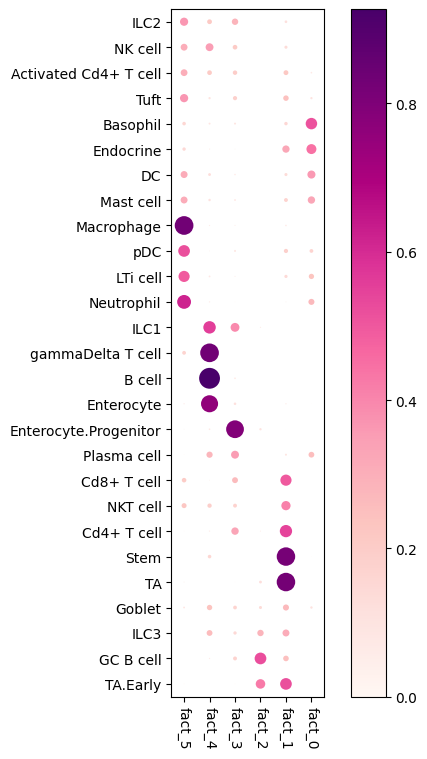

In [18]:
res_dict['n_fact6']['mod'].plot_cell_type_loadings()


In [19]:
merge_dataset_sb.obsm['spatial'] = merge_dataset_sb.obsm['old_spatial'].copy()
merge_dataset_sb.obs.columns

Index(['in_tissue', 'array_row', 'array_col', 'total_counts', 'location',
       'spot_id', 'basement_layer', 'centre', 'sections', 'leiden_cluster',
       'length', 'depth', 'unrolledSections', '_indices', '_scvi_batch',
       '_scvi_labels', 'Activated Cd4+ T cell', 'B cell', 'Basophil',
       'Cd4+ T cell', 'Cd8+ T cell', 'DC', 'Endocrine', 'Enterocyte',
       'Enterocyte.Progenitor', 'GC B cell', 'Goblet', 'ILC1', 'ILC2', 'ILC3',
       'LTi cell', 'Macrophage', 'Mast cell', 'NK cell', 'NKT cell',
       'Neutrophil', 'Plasma cell', 'Stem', 'TA', 'TA.Early', 'Tuft',
       'gammaDelta T cell', 'pDC', 'sample', 'mean_nUMI_factorsfact_0',
       'mean_nUMI_factorsfact_1', 'mean_nUMI_factorsfact_2',
       'mean_nUMI_factorsfact_3', 'mean_nUMI_factorsfact_4',
       'mean_nUMI_factorsfact_5', 'mean_nUMI_factorsfact_6'],
      dtype='object')

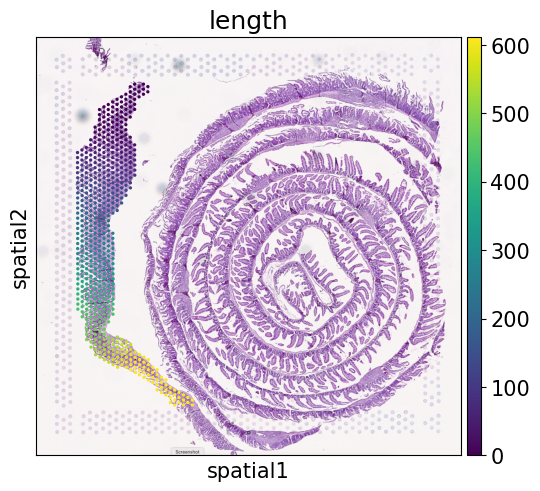

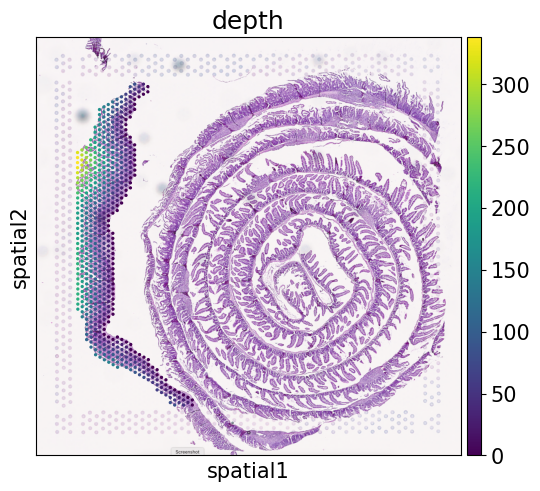

In [20]:
matplotlib.rcParams.update({'font.size': 15})

sq.pl.spatial_scatter(merge_dataset_sb, color = "length")
sq.pl.spatial_scatter(merge_dataset_sb, color = "depth")


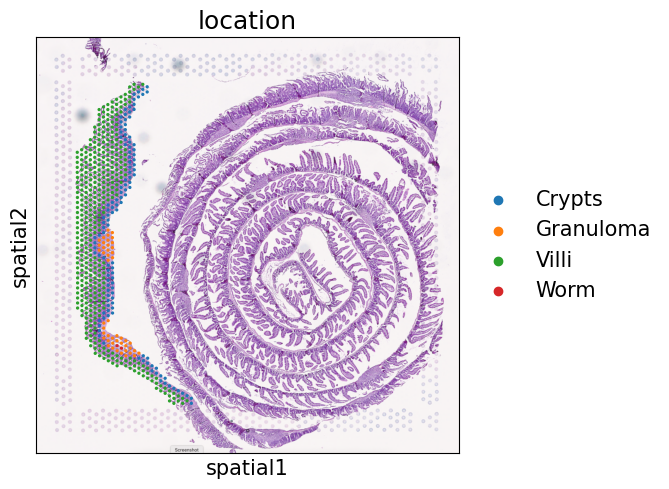

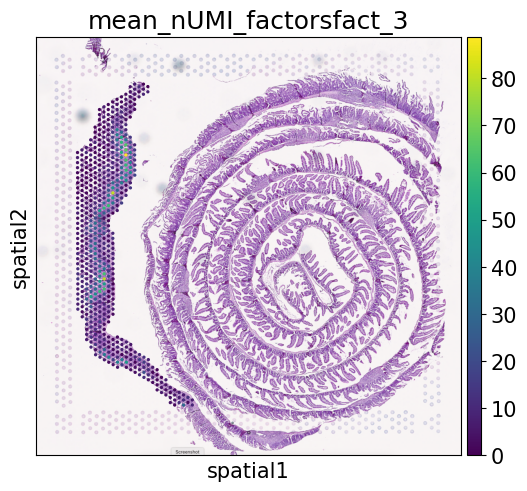

In [21]:
sq.pl.spatial_scatter(merge_dataset_sb, color = "location")


sq.pl.spatial_scatter(merge_dataset_sb, color = "mean_nUMI_factorsfact_3")


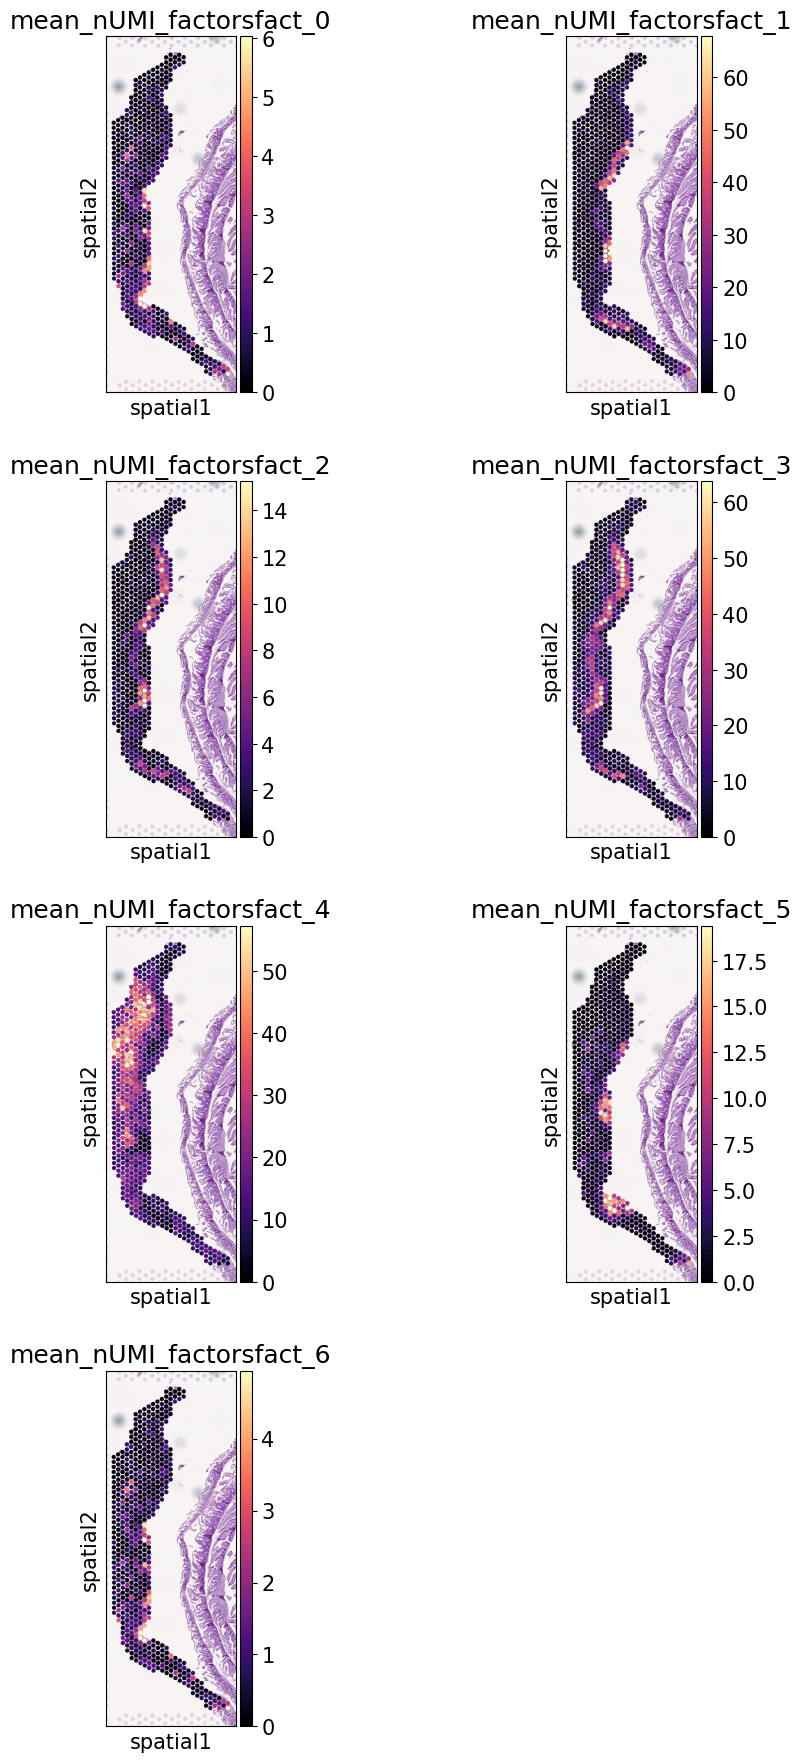

In [22]:
factor_ids = ['mean_nUMI_factorsfact_0',
       'mean_nUMI_factorsfact_1', 'mean_nUMI_factorsfact_2',
       'mean_nUMI_factorsfact_3', 'mean_nUMI_factorsfact_4',
             'mean_nUMI_factorsfact_5',
             'mean_nUMI_factorsfact_6']

import matplotlib as mpl
# select one slide
from cell2location.utils import select_slide

with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    matplotlib.rcParams.update({'font.size': 15})
    
    sc.pl.spatial(merge_dataset_sb, cmap='magma',
                  # show first 8 cell types
                  color=factor_ids,
                  ncols=2, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

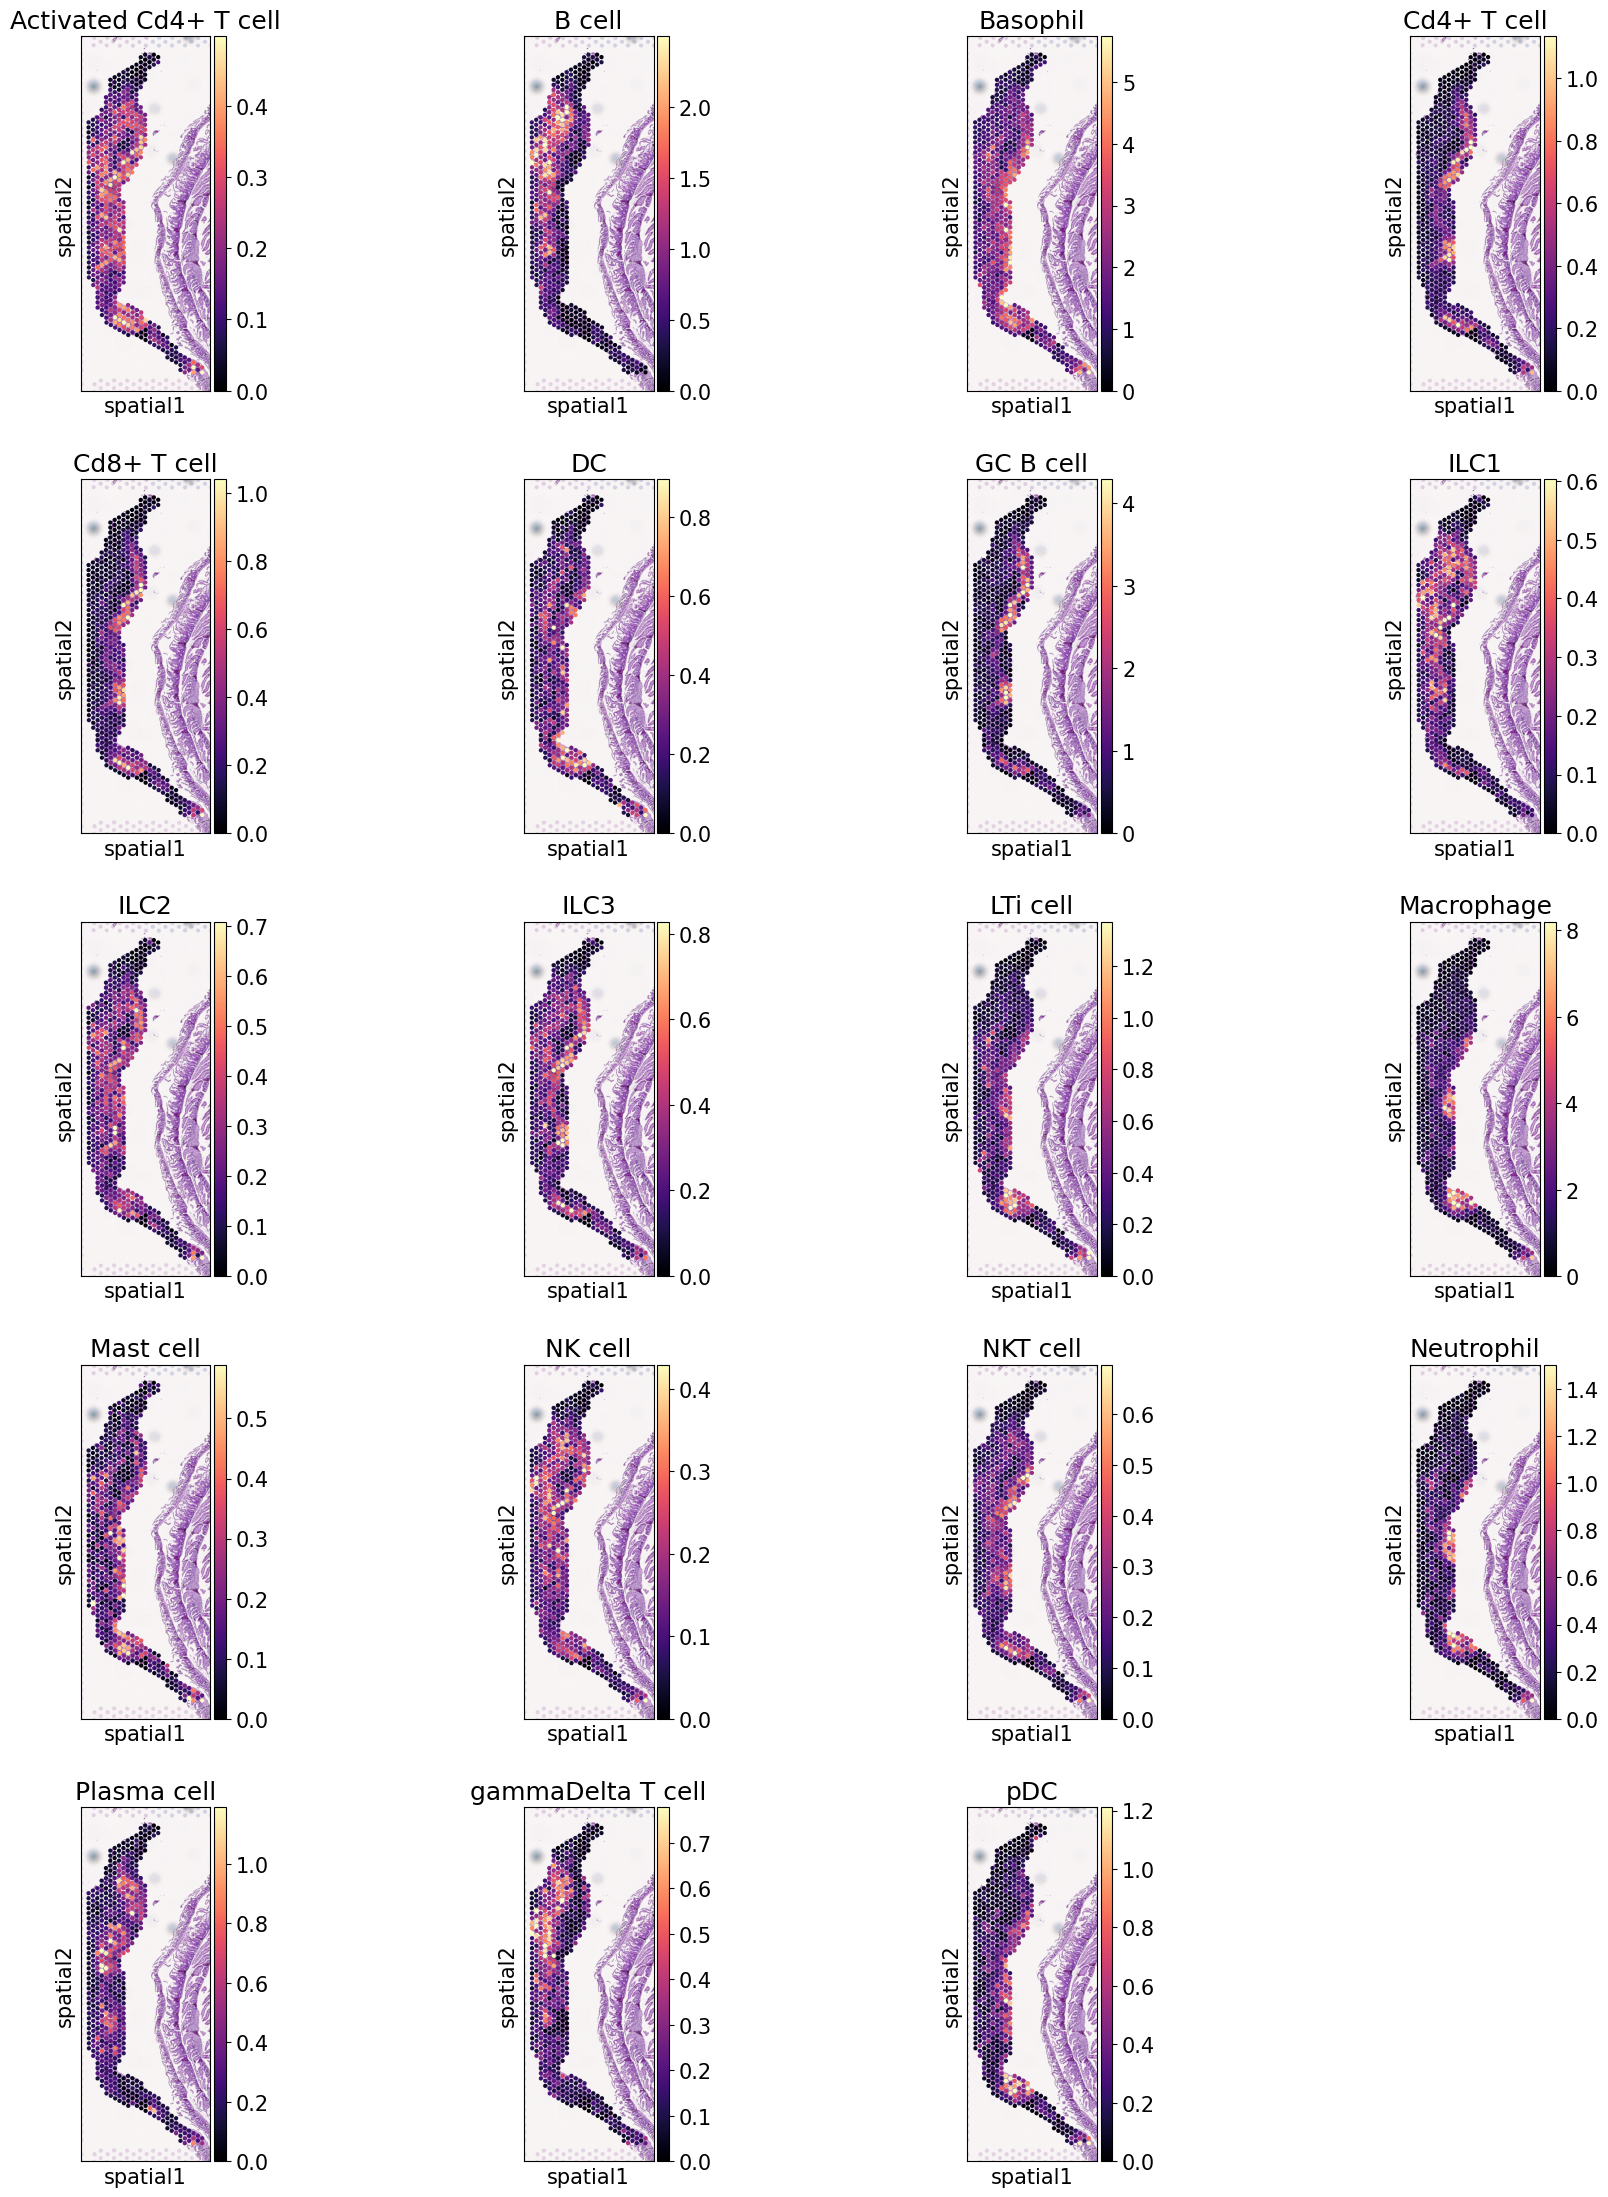

In [23]:
immune_cells = ['Activated Cd4+ T cell', 'B cell', 'Basophil', 'Cd4+ T cell',
       'Cd8+ T cell', 'DC', 
       'GC B cell',  'ILC1', 'ILC2', 'ILC3', 'LTi cell', 'Macrophage',
       'Mast cell', 'NK cell', 'NKT cell', 'Neutrophil', 'Plasma cell', 'gammaDelta T cell',
       'pDC']

nonImmune_cells = ['Endocrine', 'Enterocyte', 'Enterocyte.Progenitor',
       'Goblet','Stem', 'TA', 'TA.Early', 'Tuft', ]

import matplotlib as mpl
# select one slide
from cell2location.utils import select_slide

with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):
    
    matplotlib.rcParams.update({'font.size': 15})
    
    sc.pl.spatial(merge_dataset_sb, cmap='magma',
                  # show first 8 cell types
                  color=immune_cells,
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

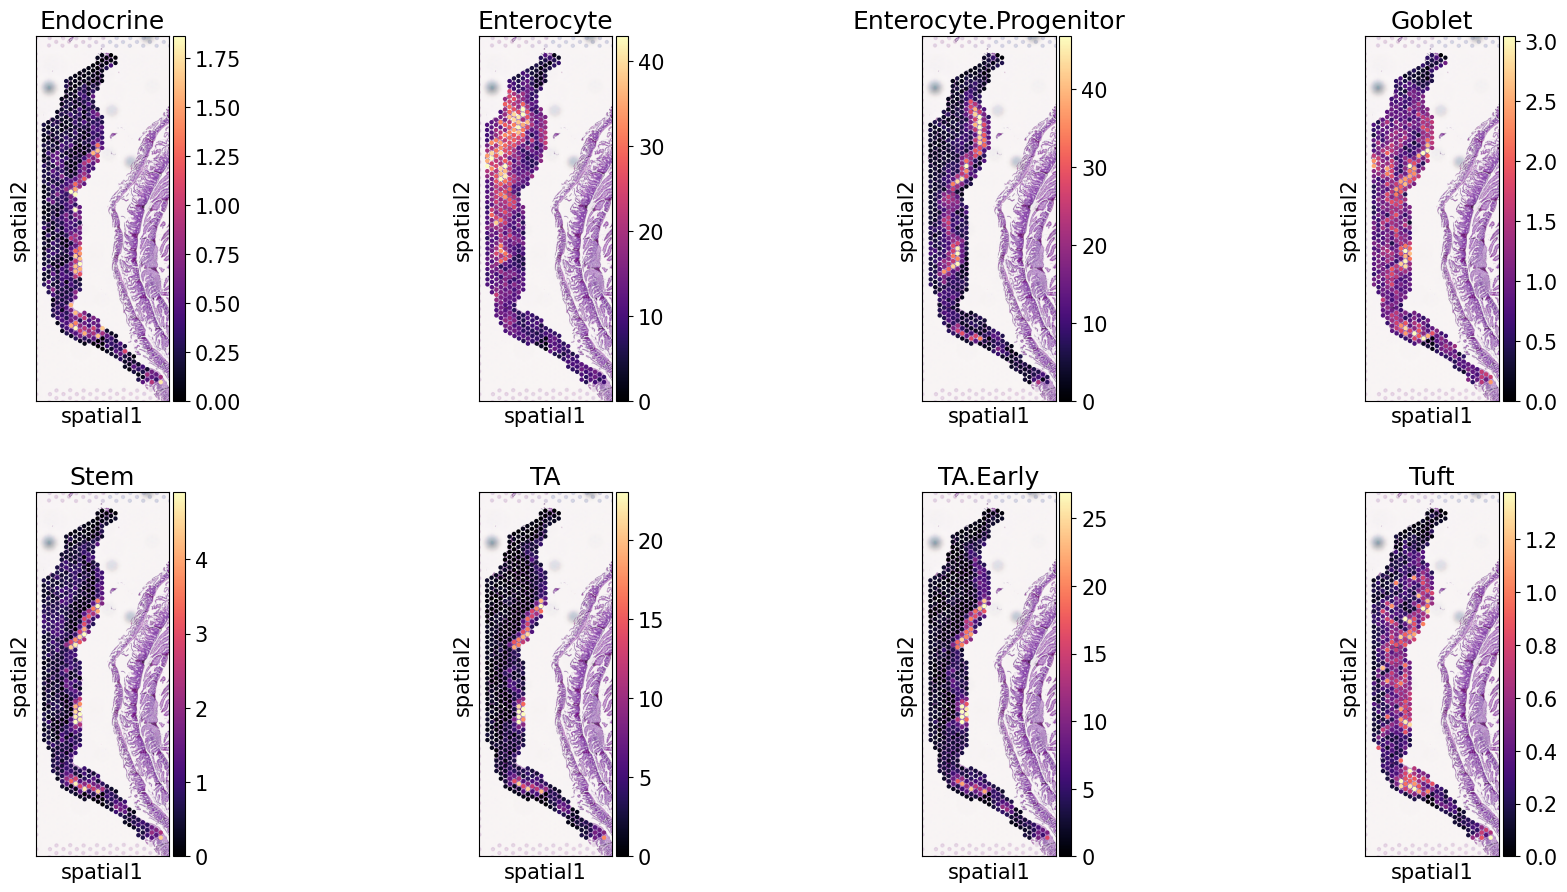

In [24]:
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    matplotlib.rcParams.update({'font.size': 15})
    
    sc.pl.spatial(merge_dataset_sb, cmap='magma',
                  # show first 8 cell types
                  color=nonImmune_cells,
                  ncols=4, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

In [316]:
merge_dataset_sb.write("/datastore3/RossOlympia/paper_analysis_MergeSplitUnroll/day7_2/day7_2_subset_c2l_NMF.h5ad")